**Chapter 3 – Classification**

Self Editing, along with own comments learnt from the book

Different from original book source code.

In [1]:
# Timing Code 

import pytz
import time
import datetime

t0 = time.time()
now_utc = datetime.datetime.utcnow()
ist_tz = pytz.timezone('Asia/Kolkata')
now_ist = now_utc.astimezone(ist_tz)
print("Current time in IST:", now_ist.strftime("%Y-%m-%d %H:%M:%S %Z%z"))

Current time in IST: 2023-04-21 20:10:22 IST+0530


# Setup

This project requires Python 3.7 or above:

In [10]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [11]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Defining the default font sizes to make the figures prettier:

In [12]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/classification` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [13]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

Hello World of Machine Learning

### fetching MNIST data using sklearn
OpenML.org


In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # False, or it would return Pandas dataframe as default

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
# Dataset decription
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
print(mnist.categories)

{}


In [5]:
# Data - 2D numpy array, target - 1D numpy array
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# 70000 images , 28x28 pixels
X.shape

(70000, 784)

7000 images,   
28x28 pixels,  
784 features,   
each feature representing one pixel's intensity : 0-white, 1-black



In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
y.shape

(70000,)

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Converting array to images 

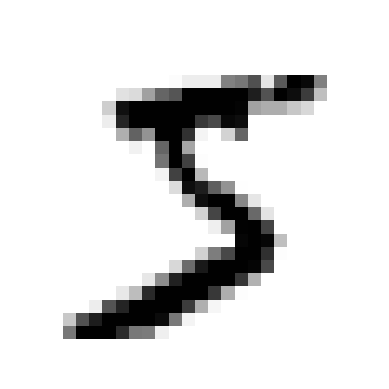

In [14]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
#save_fig("some_digit_plot")  # extra code
plt.show()

In [15]:
y[0]

'5'

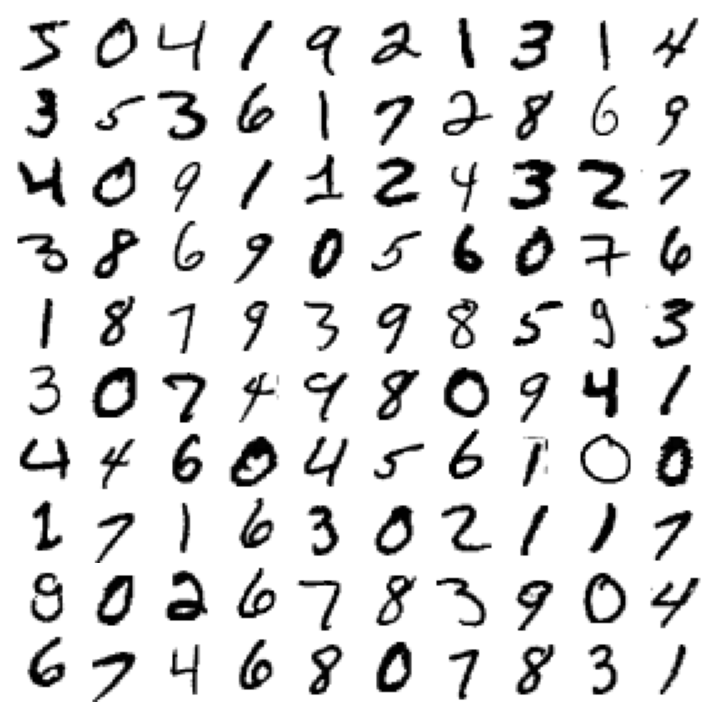

In [16]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

# Training a Binary Classifier

**"5" Detector**

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5

In [19]:
# Creating target vector for classification task 
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Let’s pick a classifier and train it. A good place to start is with a **stochastic gradient descent (SGD, or stochastic GD) classifier**, using Scikit-Learn’s SGDClassifier class. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning,

In [20]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:


In [21]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor

## Measuring Accuracy Using Cross-Validation

Let’s use the cross_val_score() function to evaluate our SGDClassifier model, using k-fold cross-validation with three folds. Remember that k-fold cross-validation means splitting the training set into k folds (in this case, three), then training the model k times, holding out a different fold each time for evaluation. 

In [22]:
# Accuracy on the test set
from sklearn.metrics import accuracy_score
y_pred = sgd_clf.predict(X_test)
accuracy = accuracy_score(y_test_5, y_pred)


In [23]:
accuracy

0.9492

In [20]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)


NameError: ignored

Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it?

let’s look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5):

**From ChatGPT**  
***DummyClassifier*** is a classifier that makes predictions using simple rules. **It can be used as a baseline model for classification tasks** where the classes are imbalanced or where the data contains a lot of noise. The DummyClassifier can make two types of predictions:

 -   "most frequent" - Always predicts the most frequent class in the training data.   
 -  "stratified" - Randomly predicts each class with a probability proportional to the class frequencies in the training data.

In [21]:
from sklearn.dummy import DummyClassifier 

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # The any() function in Python returns True if any element of the given iterable is True, otherwise it returns False

# It should print out False, thats what its designed to do 


False


Checking this model's accuracy 

In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. 

So the SGD classifier was only am improvement of 5%, ie 95% over baseline model. 

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

## Implementing Cross Validation 

Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross- validation yourself. The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and it prints the same result:

In [23]:
# sklearn.model_selection.StratifiedKFold is a cross-validation technique 
# used for classification tasks to ensure that each fold is made by 
# preserving the percentage of samples for each class. 
# This is important when dealing with imbalanced datasets, 
# where one class has a much smaller number of samples compared to the other class(es).


# The StratifiedKFold function splits the data into K folds, 
# ensuring that each fold has the same proportion of the target classes as the complete dataset. 
# It returns indices that can be used to index into the original data array 
# to retrieve the training and validation sets for each fold.

# The clone function in scikit-learn creates a new estimator 
# with the same parameters as the original estimator. 
# It is useful in situations where you want to create 
# multiple instances of an estimator with the same parameters.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # Add shuffle=True if dataset is not already shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred)) # prints percentage 




0.95035
0.96035
0.9604


## Confusion Matrix

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. For example, to know the number of times the classifier confused images of 8s with 0s, you would look at row #8, column #0 of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). 

Instead, you can use the cross_val_predict() function:

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predic‐ tions made on each test fold. 

In [25]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives, also called type II errors), while the remaining 3,530 were correctly classified as 5s (true positives).

[true negative, false positive]  
[false negative, true positive] 


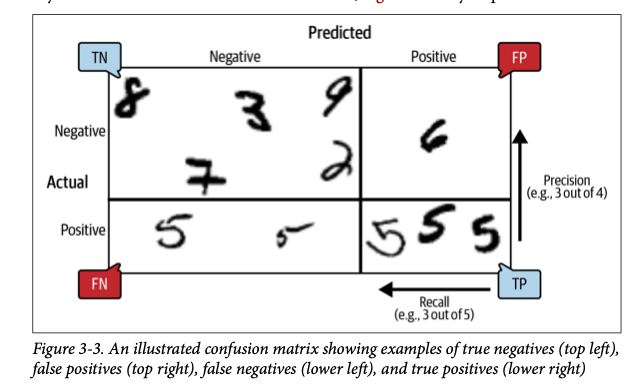

A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right

In [27]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

Precision is the fraction of true positive examples among the examples that the model classified as positive. In other words, the number of true positives divided by the number of false positives plus true positives.

In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # = 3530/(687+3530)

0.8370879772350012

In [29]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

Recall, also known as sensitivity, is the fraction of examples classified as positive, among the total number of positive examples. In other words, the number of true positives divided by the number of true positives plus false negatives.

In [30]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [31]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.


In [32]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [33]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## Precision/Recall Trade-off

**Classifier Score**  

how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

"Classifier score" typically refers to the output of a classification model, which is a numerical value indicating the degree of confidence that the model has in its prediction for a particular input.

The score could be a probability value between 0 and 1, indicating the likelihood of a given input belonging to a particular class, or it could be a decision value that represents the model's confidence in its prediction. The higher the score, the more confident the model is in its prediction for the input.



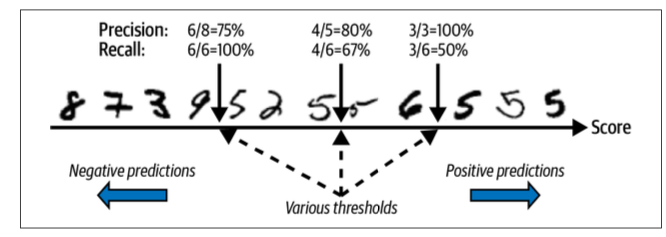

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.

In [34]:
# Instead of calling the classifier’s predict() method, 
# you can call its decision_function() method, 
# which returns a score for each instance, 
# and then use any threshold you want to make predictions based on those scores:

y_scores = sgd_clf.decision_function([some_digit]) # decision_function(X) : Predict confidence scores for samples.
                                                    # Accept confidence scores as a black box for now
y_scores

array([2164.22030239])

In [35]:
# The SGDClassifier uses a threshold equal to 0, 
# so this  code returns the same result as the predict() method (i.e., True)
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [36]:
y_some_digit_pred # SHould be True

array([ True])

In [37]:
a = sgd_clf.predict([some_digit])
a

array([ True])

In [38]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([ True])

In [39]:
# raise the threshold:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

My understading : So what has happened till now is you have trained your classifier, ie sgd_clf using the data, and now we are evaluating. the classifier has done something and gives a cofidence score to each instance we check it on, and when we use predict(), its again giving it a score. by chaning the threshold, we can tell the model to be more precise, or more recall. 

raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

More info, refer to this : [3.1.1.2. Obtaining predictions by cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#obtaining-predictions-by-cross-validation)

In [40]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds 

The precision_recall_curve() function takes as input the true labels of a binary classification problem and the predicted probabilities of the positive class. It then computes precision and recall values for different probability thresholds by varying the threshold from 0 to 1 in small increments. The output of the function is an array of precision values, an array of recall values, and an array of threshold values.

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

**Precisin, Recall vs Threshold**

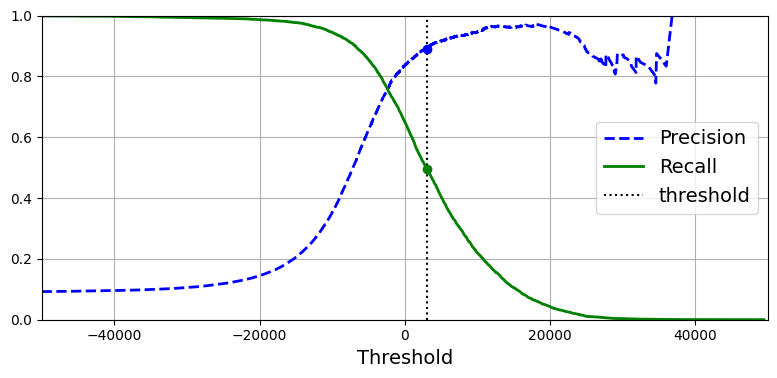

In [42]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

that precision may sometimes go down when you raise the threshold (although in general it will go up). 


recall can only go down when the threshold is increased, which explains why its curve looks smooth

Another way to select a good precision/recall trade-off is to plot precision directly against recall

**Precision versus recall Curve**

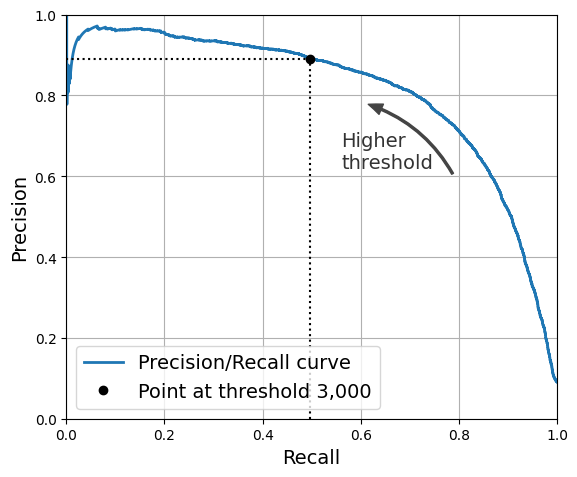

In [43]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

an see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

**90% Precision**

 could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the NumPy array’s argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [48]:
idx_for_90_precision = (precisions >= 0.90).argmax() # 0.90, not 90 lol
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:

In [49]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Checking predictions precision and recalls

In [50]:
precision_score(y_train_5, y_train_pred_90)

# it should be 90 

0.9000345901072293

In [51]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

 **it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast–a high-precision classifier is not very useful if its recall is too low!** For many applications, 48% recall wouldn’t be great at all.

## The ROC Curve

 **ROC curve** plots the **true positive rate (another name for recall) against the false positive rate (FPR)**. The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The **TNR is also called specificity**. Hence, the **ROC curve plots sensitivity (recall) versus 1 – specificity**.

In [52]:
# Computing the ROC curve at differernt threshold values 

from sklearn.metrics import roc_curve 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)



**FPR vs TPR**

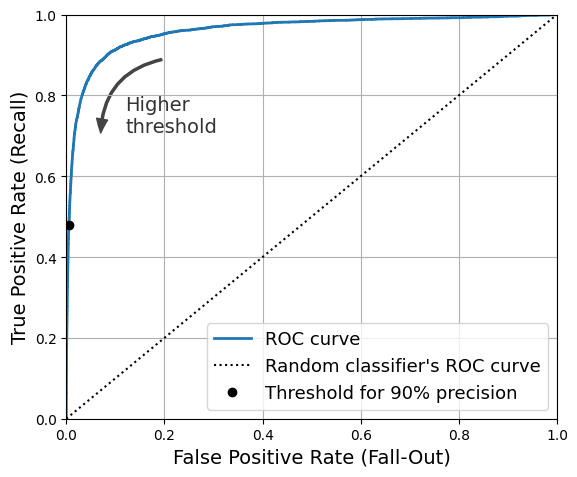

In [53]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; **a good classifier stays as far away from that line as possible (toward the top-left corner)**.

compare classifiers is to measure the **area under the curve (AUC)**. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Warning:** the following cell may take a few minutes to run.

**As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.**

The PR curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner

###Random Forest Classifier and Comparison with SGD

Let’s now create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier:

In [55]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)


The precision_recall_curve() function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance. But the RandomForestClassifier class does not have a decision_function() method, due to the way it works 

it has a predict_proba() method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine.

We can call the cross_val_predict() function to train the Random ForestClassifier using cross-validation and make it predict class probabilities for every image as follows

In [56]:
import time
t2 = time.time()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
print(F"took:{time.time()-t2:.2f} secs to run")

took:92.25 secs to run


class probabilities for the first two images in the training set:


In [58]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the probabilities in each row add up to 100%.


These are _estimated probabilities_. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [59]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


if you look at all the images that the model classified as positive with an estimated probability between 50% and 60%, roughly 94% of them are actually positive. So, the model’s estima‐ ted probabilities were much too low in this case. 

Means model is underconfident in this case 

second column contains the estimated probabilities for the positive class, so let’s pass them to the precision_recall_curve() function:

In [62]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest , recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

**Comparing SGD and Forest PRC**

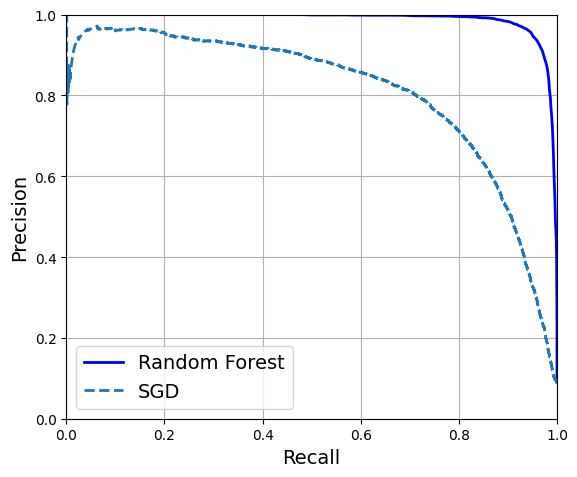

In [63]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

**the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner, and it has a greater AUC**

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [64]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [66]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [67]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. 

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [14]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # using the full y_train

SVC(random_state=42)

In [15]:
some_digit = X[0]
svm_clf.predict([some_digit])

array(['5'], dtype=object)

This code actually made 45 predictions—one per pair of classes—and it selected the class that won the most duels. If you call the decision_function() method, you will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max ±0.33) to break ties, based on the classifier scores:

In [16]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [17]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value.

In [18]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

you will need to look up the **class label** like this:

In [26]:
svm_clf.classes_[class_id]

'5'

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: **`SVC` always uses OvO for training**. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [19]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. 

Create an instance and pass a classifier to its constructor (it doesn’t even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [20]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [21]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

number of trained classifiers

In [22]:
len(ovr_clf.estimators_)

10

**Multiclass SGD Classifier**

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Incorrect result. Classifier made a mistake

This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The decision_function() method now returns one value per class. 

In [24]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

You can see that the classifier is not very confident about its prediction: almost all scores are very negative, while class 3 has a score of +1,824, and class 5 is not too far behind at –1,386.

**Warning:** the following two cells may take a few minutes each to run:

In [25]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. 

Simply scaling the inputs increases accuracy above 89.1%:

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype("float32"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy",verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.898) total time= 5.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s


[CV] END ................................ score: (test=0.892) total time= 4.9min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.0min remaining:    0.0s


[CV] END ................................ score: (test=0.901) total time= 5.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.0min finished


array([0.8979 , 0.89215, 0.9008 ])

# Error Analysis

Now we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.


**confusion matrix**

 For this, you first need to make predictions using the cross_val_predict() function; then you can pass the labels and predictions to the confusion_matrix() function, just like you did earlier. However, since there are now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers, and it may be hard to read.

A colored diagram of the confusion matrix is much easier to analyze. To plot such a diagram, use the `ConfusionMatrixDisplay.from_predictions()` function like this:

**Warning:** the following cell will take a few minutes to run:

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype("float32"))

from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, verbose=20)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.8min finished


NameError: ignored

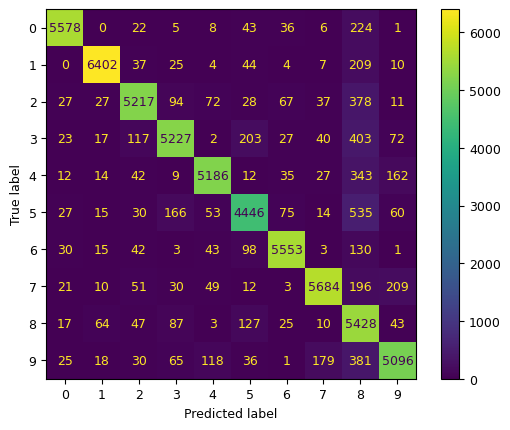

In [12]:
import matplotlib.pyplot as plt

plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

most images are on the main diagonal, which means that they were classified correctl

Notice that the cell on the diagonal in row #5 and column #5 looks slightly darker than the other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than the other digits.it’s important to normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class (i.e., divide by the row’s sum). This can be done simply by setting normalize="true".

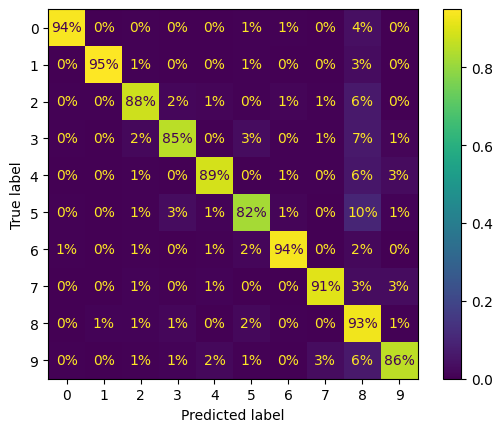

In [13]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

confusion matrices are generally not symmetrical! 


---


If you look carefully, you will notice that many digits have been misclassified as 8s, but this is not immediately obvious from this diagram. If you want to make the errors stand out more, you can try putting zero weight on the correct predictions.

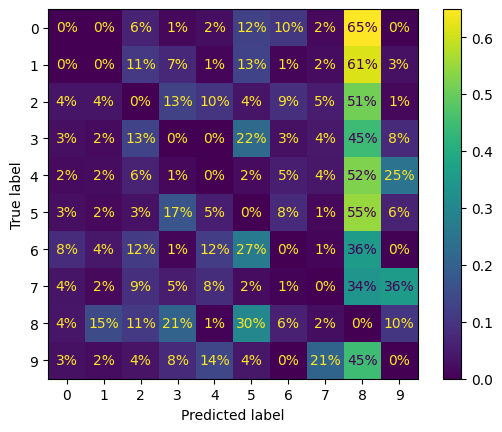

In [14]:
sample_weight = (y_train_pred != y_train) # Predicting the opposite of correct 
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

The column for class 8 is now really bright, which confirms that many images got misclas‐ sified as 8s. In fact this is the most common misclassification for almost all classes. 

But be careful how you **interpret the percentages in this diagram**: remember that we’ve excluded the correct predictions. 

For example, the 36% in row #7, column #9 does not mean that 36% of all images of 7s were misclassified as 9s. 
    
It means that 36% of the errors the model made on images of 7s were misclassifications as 9s. only 3% of images of 7s were misclassified as 9s,

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at these plots, it seems that your efforts should be spent on reduc‐ ing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

Let's put all plots in a couple of figures for the book:

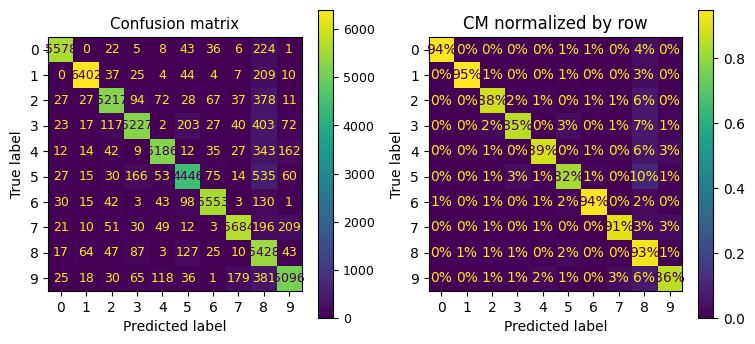

In [16]:
# extra code – this cell generates and saves Figure 3–9
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
#save_fig("confusion_matrix_plot_1")
plt.show()

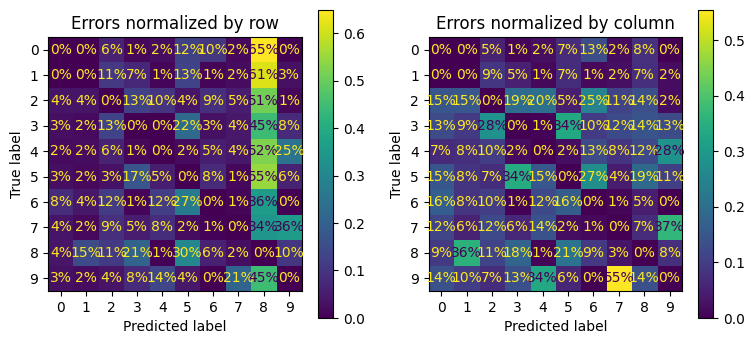

In [18]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
#save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

that 56% of misclassified 7s are actually 9s.

Analyzing individual errors can also be a good way to gain insights into what your classifier is doing and why it is failing. For example, let’s plot examples of 3s and 5s in a confusion matrix style

In [21]:
cl_a, cl_b = '3', '8'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

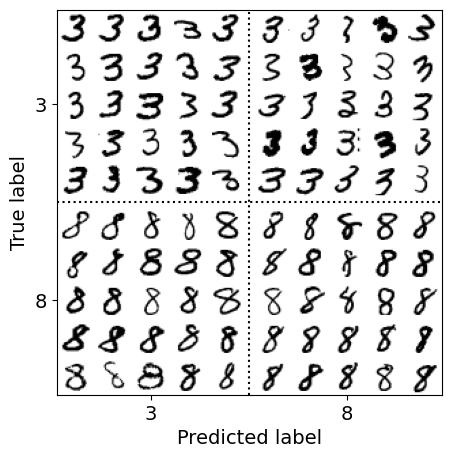

In [22]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
#save_fig("error_analysis_digits_plot")
plt.show()

Note: there are several other ways you could code a plot like this one, but it's a bit hard to get the axis labels right:
* using [nested GridSpecs](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html)
* merging all the digits in each block into a single image (then using 2×2 subplots). For example:
    ```python
    X_aa[:25].reshape(5, 5, 28, 28).transpose(0, 2, 1, 3).reshape(5 * 28, 5 * 28)
    ```
* using [subfigures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) (since Matplotlib 3.4)

# Multilabel Classification

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd. Then the code creates a KNeighborsClassifier instance, which supports multilabel classification (not all classifiers do), and trains this model using the multiple targets array

In [23]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [25]:
some_digit = X[0]
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).

**Warning**: the following cell may take a few minutes to run:

In [26]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)


NameError: ignored

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. The following code computes the average F1 score across all labels:

This approach assumes that all labels are equally important, which may not be the case.

In [27]:
from sklearn.metrics import f1_score
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" when calling the f1_score() function.5


In [28]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [31]:
from sklearn.multioutput import ClassifierChain
from sklearn.svm import SVC

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42, verbose=True)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

[Chain] ................... (1 of 2) Processing order 0, total=   1.0s
[Chain] ................... (2 of 2) Processing order 1, total=   1.2s


ClassifierChain(base_estimator=SVC(), cv=3, random_state=42, verbose=True)

In [32]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification

let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). This is thus an example of a multioutput classification system.

In [33]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

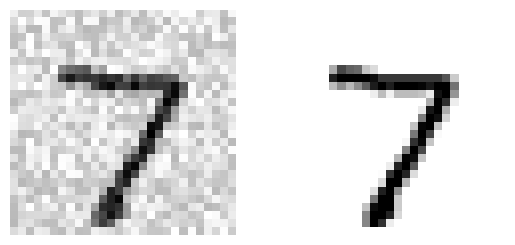

In [38]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
#save_fig("noisy_digit_example_plot")
plt.show()

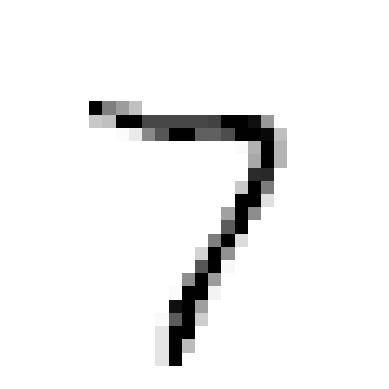

In [41]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod,)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
#save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()

# Exercise solutions

## 1. An MNIST Classifier With Over 97% Accuracy

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

Let's start with a simple K-Nearest Neighbors classifier and measure its performance on the test set. This will be our baseline:

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

Great! A regular KNN classifier with the default hyperparameters is already very close to our goal.

Let's see if tuning the hyperparameters can help. To speed up the search, let's train only on the first 10,000 images:

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [17]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [18]:
grid_search.best_score_

0.9441999999999998

The score dropped, but that was expected since we only trained on 10,000 images. So let's take the best model and train it again on the full training set:

In [19]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

We reached our goal of 97% accuracy! 🥳

## 2. Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

Let's try augmenting the MNIST dataset by adding slightly shifted versions of each image.

In [20]:
from scipy.ndimage import shift

In [21]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Let's see if it works:

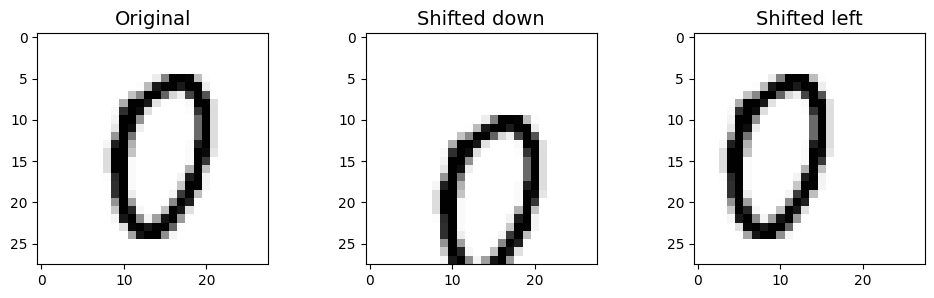

In [22]:
image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

Looks good! Now let's create an augmented training set by shifting every image left, right, up and down by one pixel:

In [23]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

NameError: ignored

Let's shuffle the augmented training set, or else all shifted images will be grouped together:

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Now let's train the model using the best hyperparameters we found in the previous exercise:

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

**Warning**: the following cell may take a few minutes to run:

In [ ]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

By simply augmenting the data, we've got a 0.5% accuracy boost. Perhaps it does not sound so impressive, but it actually means that the error rate dropped significantly:

In [ ]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

The error rate dropped quite a bit thanks to data augmentation.

## 3. Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

Let's fetch the data and load it:

In [36]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [37]:
train_data, test_data = load_titanic_data()

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can on the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [38]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

Let's explicitly set the `PassengerId` column as the index column:

In [39]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Let's get more info to see how much data is missing:

In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [41]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [42]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Yikes, only 38% **Survived**! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [43]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [44]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [45]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [46]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

iris = load_iris()


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

Now we can build the pipeline for the categorical attributes:

In [48]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [49]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

Finally, let's join the numerical and categorical pipelines:

In [50]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [51]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Let's not forget to get the labels:

In [52]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with a `RandomForestClassifier`:

In [53]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

NameError: ignored

Great, our model is trained, let's use it to make predictions on the test set:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format expected by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [ ]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

Okay, not too bad! Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that our score is in the top 2%, woohoo! Some Kagglers reached 100% accuracy, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! 😆

Let's try an `SVC`:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

Great! This model looks better.

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.
  * Try to identify parts of names that correlate well with the **Survived** attribute.
  * Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

## 4. Spam classifier

Exercise: _Build a spam classifier (a more challenging exercise):_

* _Download examples of spam and ham from [Apache SpamAssassin's public datasets](https://homl.info/spamassassin)._
* _Unzip the datasets and familiarize yourself with the data format._
* _Split the datasets into a training set and a test set._
* _Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word._

_You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with "URL," replace all numbers with "NUMBER," or even perform _stemming_ (i.e., trim off word endings; there are Python libraries available to do this)._

_Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision._

In [ ]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [ ]:
ham_dir, spam_dir = fetch_spam_data()

Next, let's load all the emails:

In [ ]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [ ]:
len(ham_filenames)

In [ ]:
len(spam_filenames)

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [ ]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [ ]:
print(ham_emails[1].get_content().strip())

In [ ]:
print(spam_emails[6].get_content().strip())

Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

In [ ]:
structures_counter(spam_emails).most_common()

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [ ]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [ ]:
spam_emails[0]["Subject"]

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

And this is the resulting plain text:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")

Let's throw in some stemming! We will use the Natural Language Toolkit ([NLTK](http://www.nltk.org/)):

In [ ]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library:

In [ ]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# if running this notebook on Colab or Kaggle, we just pip install urlextract
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

**Note:** inside a Jupyter notebook, always use `%pip` instead of `!pip`, as `!pip` may install the library inside the wrong environment, while `%pip` makes sure it's installed inside the currently running environment.

In [ ]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

In [ ]:
X_few_vectors.toarray()

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [ ]:
vocab_transformer.vocabulary_

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

Over 98.5%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

In [ ]:
print("Took:{0:.2f}s".format(time.time() - t0))
now_utc = datetime.datetime.utcnow()
ist_tz = pytz.timezone('Asia/Kolkata')
now_ist = now_utc.astimezone(ist_tz)
print("Current time in IST:", now_ist.strftime("%Y-%m-%d %H:%M:%S %Z%z"))